In [15]:
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
import re
import time
import itertools
from ngram import NGram
from dateutil.parser import parse

from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
pd.options.display.max_rows = 30
pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.spatial.distance import pdist, squareform
from scipy import stats

import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
filepath = input("filepath:")
delimiter = input("delimiter: ")

filepath:insurance.csv
delimiter: 


In [3]:
if delimiter == '':
    df = pd.read_csv(filepath)
else:
    df = pd.read_csv(filepath, sep=delimiter)
df["id"] = df.index

In [4]:
print('\033[1m' + "Characteristics of Input Dataset" + '\033[0m')
print("Number of fields/characteristics:", df.shape[1])
print("Number of data entries:", df.shape[0])
print("-----------------------------------------------")
print('\033[4m' + "Number of missing entries per column:" + '\033[0m')
print(df.isnull().sum())
print("-----------------------------------------------")
print('\033[4m' + "Datatype of each column:"+ '\033[0m')
print(df.dtypes)

Characteristics of Input Dataset
Number of fields/characteristics: 8
Number of data entries: 1338
-----------------------------------------------
Number of missing entries per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
id          0
dtype: int64
-----------------------------------------------
Datatype of each column:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
id            int64
dtype: object


In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def describe(column=list(df.columns)):
    print(df[column].describe())

interactive(children=(Dropdown(description='column', options=('age', 'sex', 'bmi', 'children', 'smoker', 'regi…

In [6]:
print("-----------------------------------------------")
print('\033[4m' + "Most Common Data Entries By Column" + '\033[0m')
for column in df:
    unique_vals = df[column].unique()
    if len(unique_vals) < (df.shape[0]/10):
        print('\n'+'\033[1m' + '\033[4m' + "Column: " + column + '\033[0m')
        print(df[column].value_counts().head())

-----------------------------------------------
Most Common Data Entries By Column

Column: age
18    69
19    68
50    29
51    29
47    29
Name: age, dtype: int64

Column: sex
male      676
female    662
Name: sex, dtype: int64

Column: children
0    574
1    324
2    240
3    157
4     25
Name: children, dtype: int64

Column: smoker
no     1064
yes     274
Name: smoker, dtype: int64

Column: region
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


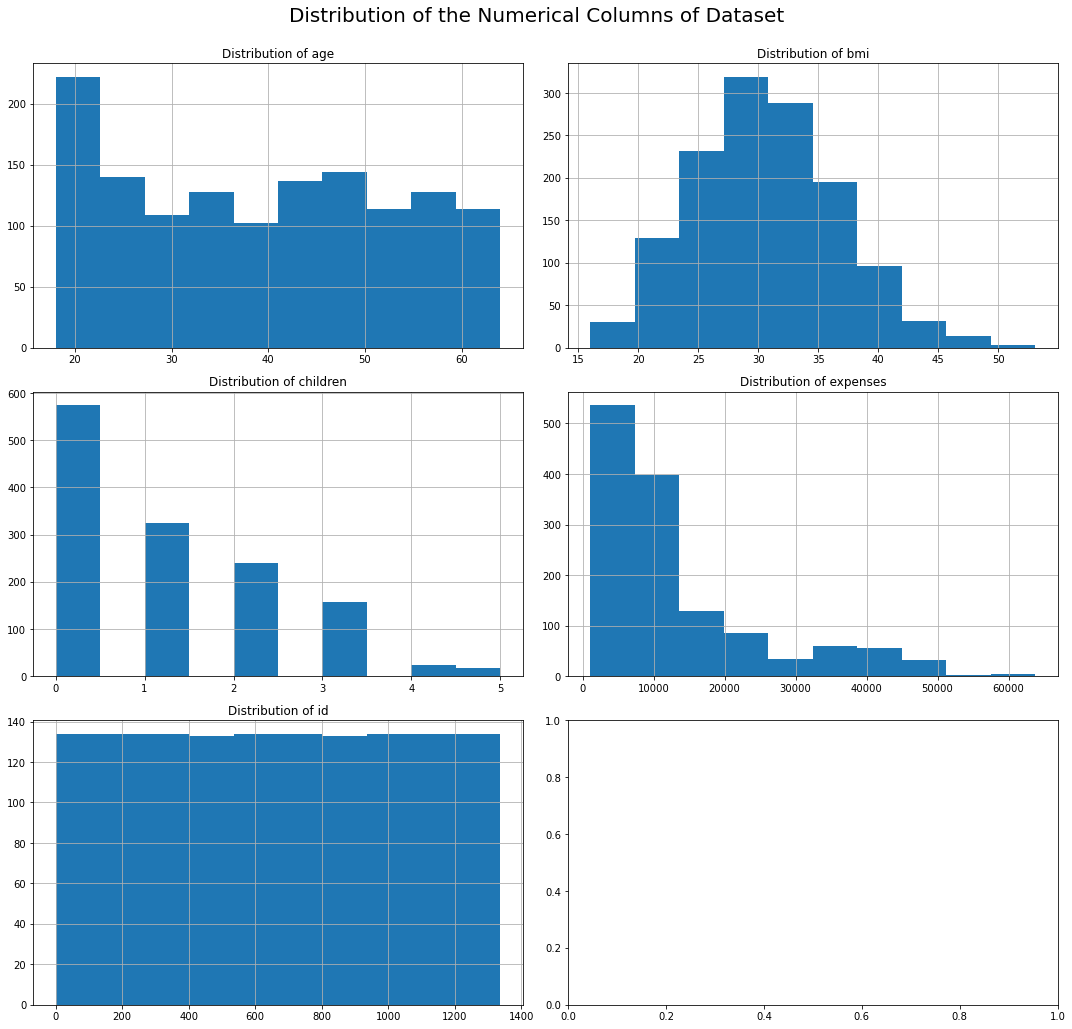

In [7]:
count = 0
numerical_columns = []
for column in df:
    if (df[column].dtypes == "int64" or df[column].dtypes == "float64"):
        numerical_columns.append(column)
        count += 1

fig, axes =  plt.subplots(math.ceil(count/2),2, figsize=(15,5 * math.ceil(count/2)))
i=0
j=0
for col in numerical_columns:
    #a[i][j].set_xlabel(col) , 
    df[col].hist(ax=axes[i][j])
    axes[i][j].set_title('Distribution of ' + col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1
plt.suptitle("Distribution of the Numerical Columns of Dataset", fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.98]);

In [8]:
from IPython.display import display

def duplicate_clean (col):
    if (not df[col].is_unique):
        print("\n The '" + col + "' column contains duplicates, what would you like do? (pick one of the following options)")
        print("(1) Keep all duplicates")
        print("(2) Drop all duplicates that are identical across all columns")
        print("(3) Drop all duplicates of this column")
        time.sleep(0.05)
        dup_option = input('\033[1m' + "Input the option number: " + '\033[0m')
        if dup_option == "1" or dup_option == "(1)":
            return
        elif dup_option == "2" or dup_option == "(2)":
            df.drop_duplicates(inplace=True)
            return
        elif dup_option == "3" or dup_option == "(3)":
            print("Please specify 'first', 'last', or 'none' to indicate which duplicate, if any, should be kept.")
            time.sleep(0.05)
            drop_pref = input('\033[1m' + "Input drop preference: " + '\033[0m')
            if drop_pref == "none":
                df.drop_duplicates([col], keep=False, inplace=True)
                return
            else:
                df.drop_duplicates([col], keep=drop_pref, inplace=True)
                return

In [9]:
# standardize the groupings of a certain column, note that the data must be non-numerical
def clean_non_numerical (col):
    
    # for non-numerical columns with unqiue values more than half the number of rows check for duplicates
    unique_vals = df[col].unique()
    if (len(unique_vals) > 30):
        return duplicate_clean(col)
    
    # do not consider date columns
    def is_date(string):
        try: 
            parse(string)
            return True
        except ValueError:
            return False
    
    # check if date is valid
    for i, row_value in df[col].head(5).iteritems():
        if is_date(df[col][i]):
            return
    
    # check for abbreviated nation names
    if ('country' in col) or ('COUNTRY' in col) or ('Country' in col):
        invalid_df_us = df[(df[col] == 'United States') | (df[col] == 'United States of America') | (df[col] == 'USA') | (df[col] == 'usa') | (df[col] == 'us')]
        if invalid_df_us.shape[0] > 0:
            print("There are " + str(invalid_df_us.shape[0])+ " alternate references to the US. These age entries will be all be set to US.")
            df.loc[(df[col] == 'United States') | (df[col] == 'United States of America') | (df[col] == 'USA') | (df[col] == 'usa') | (df[col] == 'us'), [col]] = 'US'
        invalid_df_uk = df[(df[col] == 'United Kingdom') | (df[col] == 'uk')]
        if invalid_df_us.shape[0] > 0:
            print("There are " + str(invalid_df_us.shape[0])+ " alternate references to the UK. These age entries will be all be set to UK.")
            df.loc[(df[col] == 'United Kingdom') | (df[col] == 'uk'), [col]] = 'UK'
        
    # establish starting point
    unique_vals = ['None' if x is np.nan else x for x in unique_vals]
    unique_vals = ['None' if v is None else v for v in unique_vals]
    print("\n Initial set of unqiue entries in '" + col + "' column: "+ '\033[1m' + ", ".join(unique_vals) + '\033[0m')
    
    # remove leading and trailing blank spaces
    df[col] = df[col].replace(r"^ +| +$", r"", regex=True)
    
    # standardize all text to "title case"
    def title_case(string):
        if pd.isnull(string):
            return None
        return re.sub(r"[A-Za-z]+('[A-Za-z]+)?", lambda word: word.group(0).capitalize(), string)
    df[col] = df[col].apply(lambda x: title_case(x))
    
    # compare strings of all titles to see if they can be merged
    def ngram_compare(a,b):
        if NGram.compare(a,b) > 0.4:
            print("\n", a,b)
            time.sleep(0.05)
            combine = input("Would you consider the above two entries the same? (yes/no) ")
            if combine == 'yes' or combine == 'y':
                while True:
                    time.sleep(0.05)
                    combine_to = input("To which entry would you like the text to be merged to? (input field name)")
                    if combine_to == a:
                        df[col] = df[col].replace({b: a}, regex=True)
                        return
                    elif combine_to == b:
                        df[col] = df[col].replace({a: b}, regex=True)
                        return
                    else:
                        continue
    unique_vals = df[col].unique()
    for pair in itertools.combinations(unique_vals, r=2):
        ngram_compare(*pair)
    print("\n")
    # show end point
    unique_vals = df[col].unique()
    unique_vals = ['None' if v is None else v for v in unique_vals]
    print("Final set of unqiue entries in '" + col + "' column: "+ '\033[1m' + ", ".join(unique_vals) + '\033[0m' +"\n")

In [10]:
import warnings
warnings.filterwarnings('ignore')

for column in df:
    if(df[column].dtype == object):
        clean_non_numerical (column)
print("\n")
print('\033[1m' + "** Non-Numerical Data Cleaning Complete! **" + '\033[0m')


 Initial set of unqiue entries in 'sex' column: female, male


Final set of unqiue entries in 'sex' column: Female, Male


 Initial set of unqiue entries in 'smoker' column: yes, no


Final set of unqiue entries in 'smoker' column: Yes, No


 Initial set of unqiue entries in 'region' column: southwest, southeast, northwest, northeast

 Southwest Southeast
Would you consider the above two entries the same? (yes/no) no

 Northwest Northeast
Would you consider the above two entries the same? (yes/no) no


Final set of unqiue entries in 'region' column: Southwest, Southeast, Northwest, Northeast



** Non-Numerical Data Cleaning Complete! **


In [11]:
def clean_numerical (col, df):
    
    # remove outliers
    print( "Input the number of standard deviations from the mean you are willing to include for the '" + '\033[1m' + col + '\033[0m' + "' column.")
    print("If you wish to keep outliers for this column, please write all.")
    time.sleep(0.05)
    sd = input("Input standard deviations: ")
    if sd != 'all':
        cols_outside_sd = df
        cols_outside_sd = cols_outside_sd[(np.abs(stats.zscore(df[col])) > int(sd))]
        print("There are " +'\033[1m'+ str(cols_outside_sd.shape[0]) + '\033[0m' + " rows that are outliers accoridng to your standard deviation value.")
        if cols_outside_sd.shape[0] > 0:
            print("These rows will be deleted from the original dataset.\n")
            df = df[(np.abs(stats.zscore(df[col])) < int(sd))]
        else:
            print("\n")
    
    # remove duplicates
    duplicate_clean(col)
    print("\n")
    
    
    
    # check if zip code is valid
    if ('zip' in col) or ('ZIP' in col):
        invalid_df = df[(df[col] < 1) | (df[col] > 99950)]
        if invalid_df.shape[0] > 0:
            print("There are " + str(invalid_df.shape[0])+ " invalid ZIP codes in your data. These ZIP entries will be set to null for now.\n")
            #df.drop(df[(df[col] < 1) | (df[col] > 99950)].index, inplace=True)
            df.loc[(df[col] < 1) | (df[col] > 99950), [col]] = np.nan

    
    # check if age is valid
    if ('age' in col) or ('AGE' in col):
        invalid_df = df[(df[col] < 0) | (df[col] > 120)]
        if invalid_df.shape[0] > 0:
            print("There are " + str(invalid_df.shape[0])+ " invalid ages in your data. These age entries will be set to null for now.\n")
            df.loc[(df[col] < 0) | (df[col] > 120), [col]] = np.nan

In [13]:
import warnings
warnings.filterwarnings('ignore')

for column in df:
    if(df[column].dtype == 'int64' or df[column].dtype == 'float64'):
        clean_numerical (column, df)

# Smart Duplication Removal
print("'Smart' duplication deletion: look at the numerical columns of duplicated rows and only delete duplicates that are 'similar'")
confirm = input("Confirm if you would like to run this duplicate deletion method: ")
if confirm == "yes" or confirm == "y":
    smart_dup = pd.DataFrame(1 - squareform(pdist(df.set_index('id'), lambda u,v: (u != v).mean())))
    smart_dup.values[[np.arange(smart_dup.shape[0])]*2] = 0
    smart_dup = smart_dup.mask(np.triu(np.ones(smart_dup.shape, dtype=np.bool_)))
    duplicates = smart_dup[smart_dup > 0.8]
    dup_list = np.stack(duplicates.notnull().values.nonzero()).T.tolist()
    print('\033[1m' + "Below is the set duplicated rows that our algorithm found: " + '\033[0m')
    print("Use the interactive toggle to compare the two 'similar' rows. Note that the duplicates will be deleted from the original dataframe.")
    for dup in dup_list:
        display(df.iloc[[dup[0],dup[1]],:])
    for dup in dup_list:
        try:
            df.drop(df.index[dup[0]], inplace=True)
        except:
            continue
print('\033[1m' + "** Numerical Data Cleaning Complete! **" + '\033[0m')

Input the number of standard deviations from the mean you are willing to include for the 'age' column.
If you wish to keep outliers for this column, please write all.
Input standard deviations: 1
There are 576 rows that are outliers accoridng to your standard deviation value.
These rows will be deleted from the original dataset.


 The 'age' column contains duplicates, what would you like do? (pick one of the following options)
(1) Keep all duplicates
(2) Drop all duplicates that are identical across all columns
(3) Drop all duplicates of this column
Input the option number: 2


Input the number of standard deviations from the mean you are willing to include for the 'bmi' column.
If you wish to keep outliers for this column, please write all.
Input standard deviations: 1
There are 442 rows that are outliers accoridng to your standard deviation value.
These rows will be deleted from the original dataset.


 The 'bmi' column contains duplicates, what would you like do? (pick one of the f

Visualizing the Missing Data: Completeness of Dataset


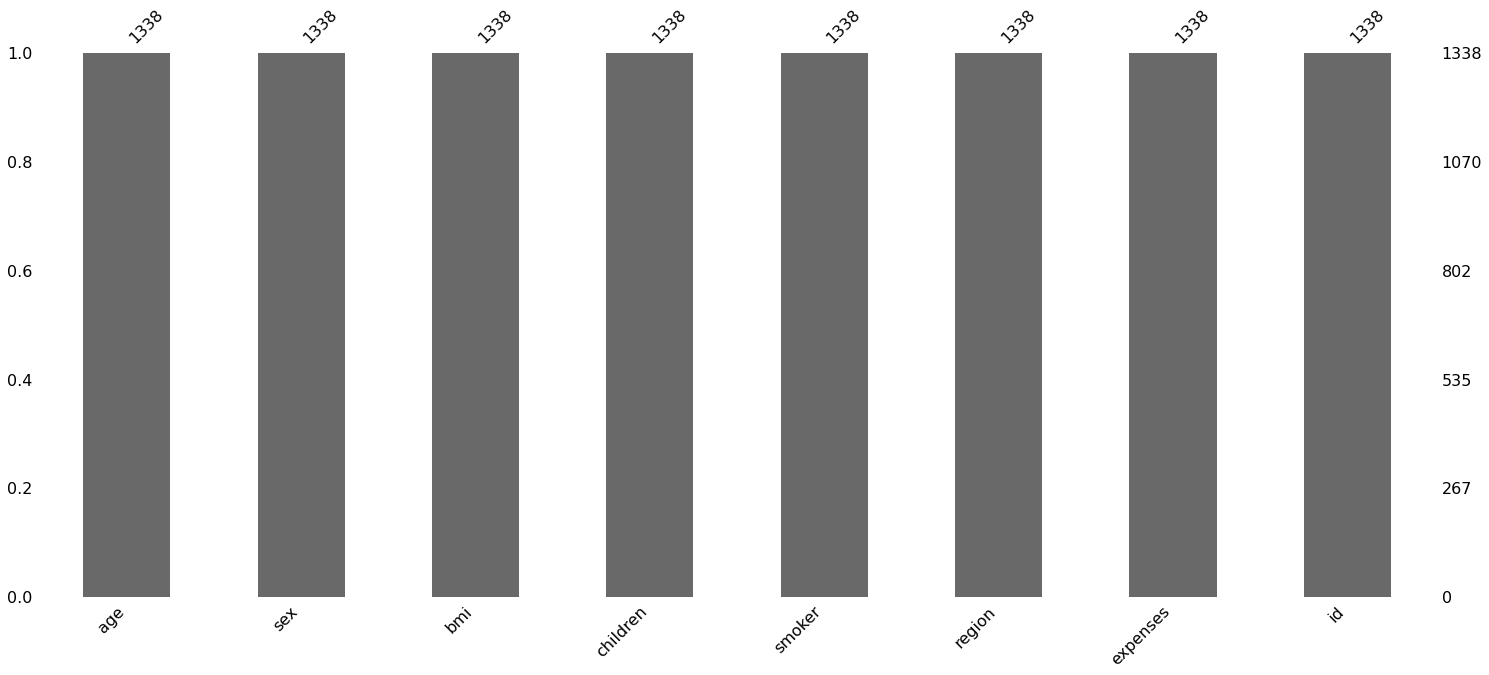

In [16]:
print('\033[1m' + "Visualizing the Missing Data: Completeness of Dataset" + '\033[0m')
msno.bar(df);

Visualizing the Missing Data: Data Completion Patterns
Note: This is from a random sample of 100 entries.


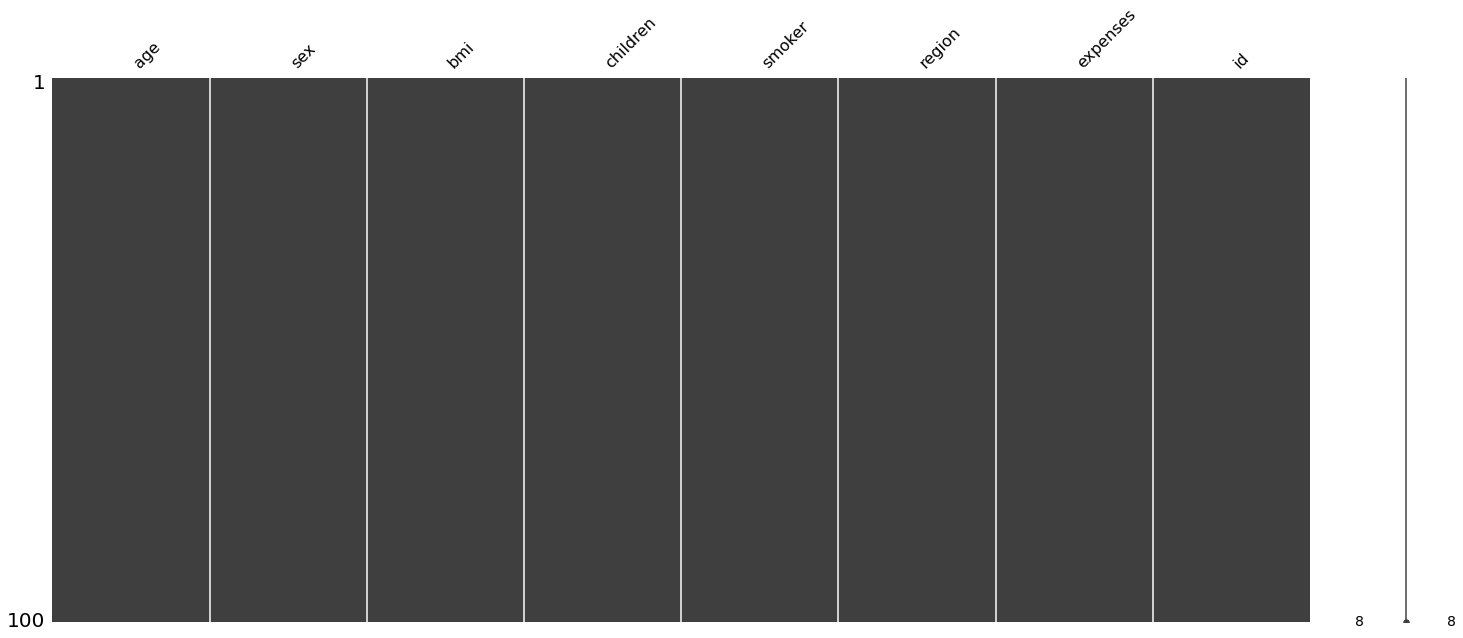

In [17]:
print('\033[1m' + "Visualizing the Missing Data: Data Completion Patterns" + '\033[0m')
print("Note: This is from a random sample of 100 entries.")
msno.matrix(df.sample(100));

Visualizing the Missing Data: Correlation Between Data


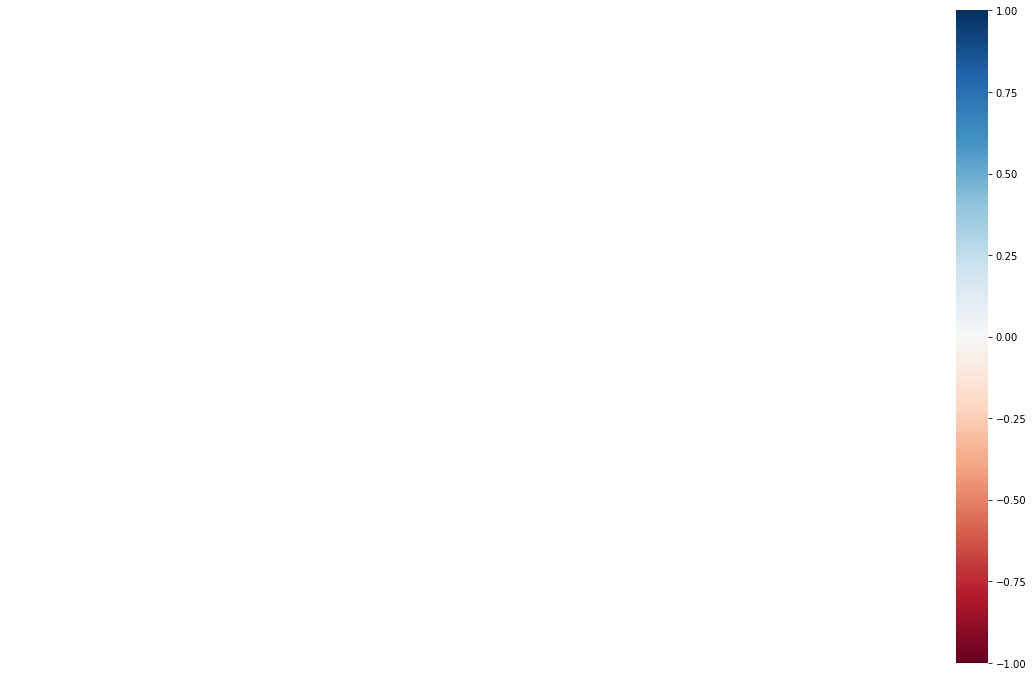

In [18]:
print('\033[1m' + "Visualizing the Missing Data: Correlation Between Data" + '\033[0m')
msno.heatmap(df);

In [19]:
for column in df:
    print("There are " + '\033[1m' + str(df[pd.isnull(df[column])].shape[0]) + '\033[0m' + " missing entries in the '" + column + "' column.")
    if df[pd.isnull(df[column])].shape[0] > 0:
        print("Pick one of the following options to handle these missing entries.")
        print("(1) Leave the missing entries as they are, so the missing values do not contribute to any computations.")
        print("(2) Drop the rows with a missing entry.")
        print("(3) Drop the entire column.")
        print("(4) Simple Imputation: Replace the missing data with a substituted value.")
        if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
            print("(5) Advanced Imputation: Using Machine Learning to substitute missing data.")
        time.sleep(0.05)
        del_option = input('\033[1m' + "Input the option number: " + '\033[0m')
        if del_option == "1" or del_option == "(1)":
            continue
        elif del_option == "2" or del_option == "(2)":
            df.dropna(subset=[column],how='any',inplace=True)
        elif del_option == "3" or del_option == "(3)":
            df.drop(columns=[column], inplace=True)
        elif del_option == "4" or del_option == "(4)":
            print("(a) Impute with a constant value.")
            print("(b) Impute with the most frequent value.")
            if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
                print("(c) Impute with the mean value of the column.")
                print("(d) Impute with the median value of the column.")
            time.sleep(0.05)
            imp_option = input('\033[1m' + "Input the letter for simple imputation: " + '\033[0m') 
            if imp_option == 'a' or imp_option == '(a)':
                constant = input('\033[1m' + "Input the constant that you wish to substitute: " + '\033[0m') 
                if (df[column].dtype == 'int64' or df[column].dtype == 'float64'):
                    mean_imputer = SimpleImputer(strategy='constant', fill_value=int(constant))
                elif(df[column].dtype == 'object'):
                    mean_imputer = SimpleImputer(strategy='constant', fill_value=constant)
            elif imp_option == 'b' or imp_option == '(b)':
                mean_imputer = SimpleImputer(strategy='most_frequent')
            elif imp_option == 'c' or imp_option == '(c)':
                mean_imputer = SimpleImputer(strategy='mean')
            elif imp_option == 'd' or imp_option == '(d)':
                mean_imputer = SimpleImputer(strategy='median')
            df[column] = mean_imputer.fit_transform(df[[column]]).ravel()
        elif del_option == "5" or del_option == "(5)":
            print("(a) Impute using the K-Nearest Neighbor Imputation. More details can be found here: https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation")
            print("(b) Impute using Multivariate imputation by chained equations (MICE). More details can be found here: https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation")
            time.sleep(0.05)
            imp_option = input('\033[1m' + "Input the letter for advanced imputation: " + '\033[0m')
            if imp_option == 'a' or imp_option == '(a)':
                knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
                df[column] = knn_imputer.fit_transform(df[[column]])
            elif imp_option == 'b' or imp_option == '(b)':
                mice_imputer = IterativeImputer()
                df[column] = mice_imputer.fit_transform(df[[column]])
    print("\n")
print('\033[1m' + "** Missing Data Cleaning Complete! **" + '\033[0m') 

There are 0 missing entries in the 'age' column.


There are 0 missing entries in the 'sex' column.


There are 0 missing entries in the 'bmi' column.


There are 0 missing entries in the 'children' column.


There are 0 missing entries in the 'smoker' column.


There are 0 missing entries in the 'region' column.


There are 0 missing entries in the 'expenses' column.


There are 0 missing entries in the 'id' column.


** Missing Data Cleaning Complete! **


In [20]:
@interact
def describe(column=list(df.columns)):
    print(df[column].describe())

interactive(children=(Dropdown(description='column', options=('age', 'sex', 'bmi', 'children', 'smoker', 'regi…

In [21]:
@interact
def hist_plot(x=list(df.select_dtypes('number').columns),
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
        
    df[x].iplot(kind='hist',
             title=f'Histogram of {x}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('age', 'bmi', 'children', 'expenses', 'id'), value='a…

In [22]:
@interact
def scatter_plot(x=list(df.select_dtypes('number').columns), 
                 y=list(df.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    print(x)
    df.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x, yTitle=y, 
             #text='title',
             title=f'Scatter Plot of {y} against {x}',
            theme=theme, colorscale=colorscale)

interactive(children=(Dropdown(description='x', options=('age', 'bmi', 'children', 'expenses', 'id'), value='a…

In [23]:
print('\033[1m' + "Export the Final Dataset" + '\033[0m')
time.sleep(0.05)
filename = input("Input the filename of the export followed by the file extension: ")
filename_spl = filename.split('.')
if filename_spl[1] == 'csv':
    df.to_csv(filename,index=False)
elif filename_spl[1] == 'csv':
    df.to_excel(filename,index=False)

Export the Final Dataset
Input the filename of the export followed by the file extension: 


IndexError: list index out of range